# Imports

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, UpSampling2D)
from tensorflow.keras.optimizers import Adam

# Dataset Preparation

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255.

In [28]:
mnist_digits_labels = np.concatenate([y_train, y_test], axis=0)
mnist_digits_labels = np.expand_dims(mnist_digits_labels, -1).astype("float32")

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(mnist_digits)

In [5]:
BATCH_SIZE = 128
LATENT_DIM = 2

In [6]:
train_dataset = (
    dataset
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [7]:
train_dataset

<PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

## Visualize Data

In [8]:
imgs = []
k = 0
for image in train_dataset.take(1).unbatch():
    imgs.append(image)
    k+=1
    if k==25:
        break

In [9]:
len(imgs)

25

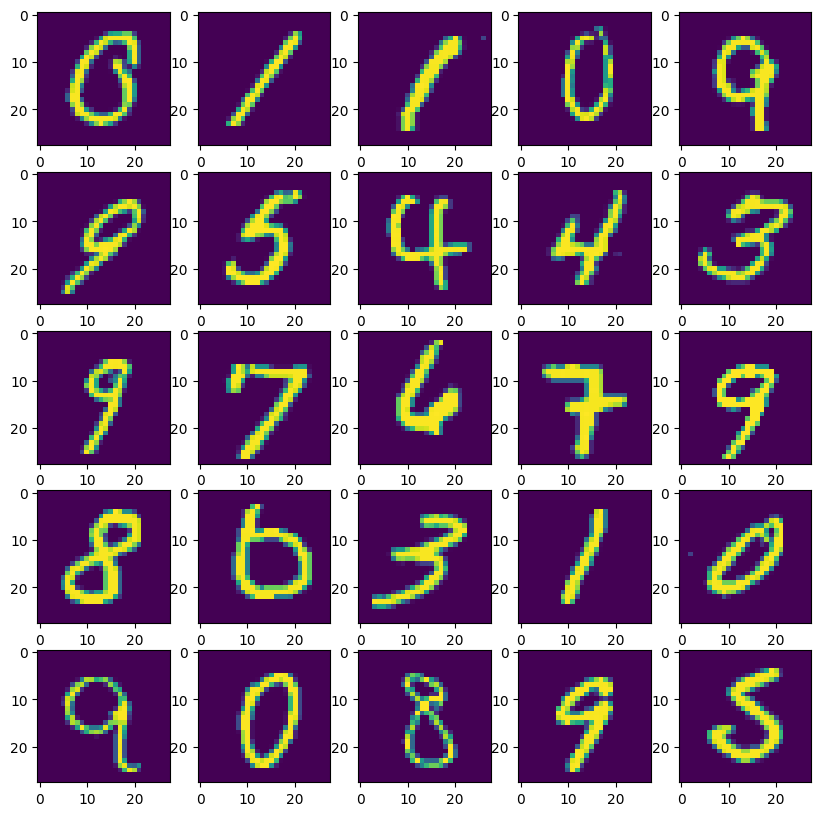

In [10]:
fig, axes = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        axes[i][j].imshow(imgs[i*5+j])

# Modeling

## Normal AutoEncoder

In [19]:
OPTIMIZER = Adam(learning_rate = 1e-3)
EPOCHS = 20

### Encoder

In [39]:
def normal_encoder(encoder_inputs):
    # encoder_inputs = Input(shape=(28,28,1))
    x = Conv2D(64, 3, activation='relu', strides=1, padding='same')(encoder_inputs)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = Conv2D(128, 3, activation='relu', strides=1, padding='same')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    bottle_neck = Conv2D(256, 3, activation='relu', strides=1, padding='same')(x)
    encoder_visualization = Conv2D(1, 3, activation='sigmoid', strides=1, padding='same')(bottle_neck)
    # encoder = Model(inputs=encoder_inputs,outputs=bottle_neck)
    return bottle_neck, encoder_visualization

### Decoder

In [42]:
def normal_decoder(decoder_inputs):
    x = Conv2D(128, 3, activation='relu', strides=1, padding='same')(decoder_inputs)
    x = UpSampling2D(size=(2,2))(x)
    x = Conv2D(64, 3, activation='relu', strides=1, padding='same')(x)
    x = UpSampling2D(size=(2,2))(x)
    decoder_output = Conv2D(1, 3, activation='sigmoid', strides=1, padding='same')(x)
    return decoder_output

### Normal AutoEncoder Model

In [45]:
def normal_auto_encoder():
    inputs = Input(shape=(28,28,1))
    bottle_neck, encoder_visualization = normal_encoder(inputs)
    outputs = normal_decoder(bottle_neck)
    ae = Model(inputs=inputs,outputs=outputs)
    encoder_model = Model(inputs=inputs,outputs=encoder_visualization)
    return ae,encoder_model

In [47]:
normal_ae,normal_encoder_model = normal_auto_encoder()
normal_ae.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 256)         2951

In [48]:
normal_encoder_model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 7, 7, 256)         295

#### Dataset Preparation form Normal AE

In [53]:
dataset_normal_ae = tf.data.Dataset.from_tensor_slices((mnist_digits,mnist_digits))
train_ds_normal_ae = (
    dataset_normal_ae
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [57]:
normal_ae.compile(
    loss='binary_crossentropy',
    optimizer=OPTIMIZER,
    metrics='mae',
    # run_eagerly=True
)

In [58]:
normal_ae.fit(train_ds_normal_ae, epochs=20)

Epoch 1/20
547/547 [==============================] - 14s 24ms/step - loss: 0.0941 - mae: 0.0352
Epoch 2/20
547/547 [==============================] - 13s 23ms/step - loss: 0.0865 - mae: 0.0295
Epoch 3/20
547/547 [==============================] - 9s 17ms/step - loss: 0.0835 - mae: 0.0273
Epoch 4/20
547/547 [==============================] - 7s 12ms/step - loss: 0.0817 - mae: 0.0259
Epoch 5/20
547/547 [==============================] - 7s 12ms/step - loss: 0.0800 - mae: 0.0246
Epoch 6/20
547/547 [==============================] - 7s 13ms/step - loss: 0.0783 - mae: 0.0234
Epoch 7/20
547/547 [==============================] - 7s 13ms/step - loss: 0.0770 - mae: 0.0223
Epoch 8/20
547/547 [==============================] - 7s 12ms/step - loss: 0.0761 - mae: 0.0216
Epoch 9/20
547/547 [==============================] - 7s 13ms/step - loss: 0.0753 - mae: 0.0210
Epoch 10/20
547/547 [==============================] - 8s 14ms/step - loss: 0.0747 - mae: 0.0205
Epoch 11/20
547/547 [================

### Visualize the Outputs

In [67]:
mnist_digits[:20].shape

(20, 28, 28, 1)

In [68]:
test_images = mnist_digits[:20]
outputs = normal_ae.predict(test_images)

1/1 [==============================] - 0s 408ms/step


In [70]:
outputs.shape

(20, 28, 28, 1)

In [78]:
encoder_visualizations = normal_encoder_model.predict(test_images)

1/1 [==============================] - 0s 79ms/step


In [79]:
encoder_visualizations.shape

(20, 7, 7, 1)

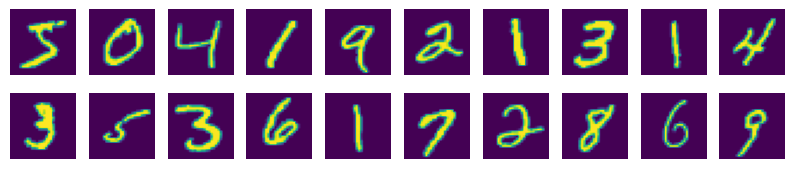

In [81]:
fig,axes = plt.subplots(2,10,figsize=(10,2))
for i in range(2):
    for j in range(10):
        axes[i][j].imshow(test_images[10*i+j])
        axes[i][j].set_axis_off()

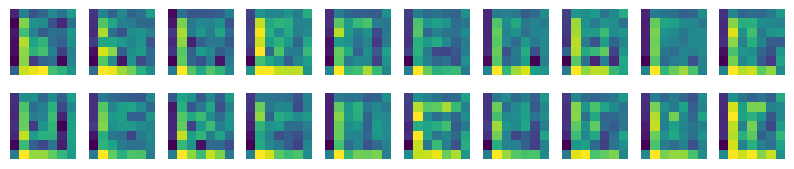

In [80]:
fig,axes = plt.subplots(2,10,figsize=(10,2))
for i in range(2):
    for j in range(10):
        axes[i][j].imshow(encoder_visualizations[10*i+j])
        axes[i][j].set_axis_off()

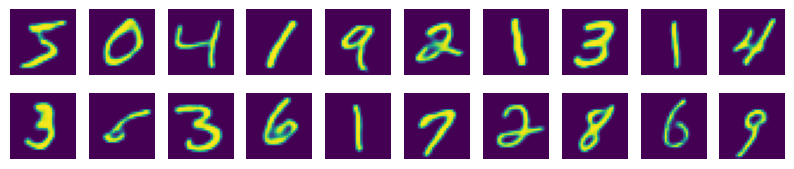

In [77]:
fig,axes = plt.subplots(2,10,figsize=(10,2))
for i in range(2):
    for j in range(10):
        axes[i][j].imshow(outputs[10*i+j])
        axes[i][j].set_axis_off()


### Let's add noise to the images and see what happens

#### Prepare Dataset with noise

In [82]:
def map_noise_to_images(image,label):
    noise_factor = 0.5*tf.random.normal(shape=image.shape)
    image_noisy = noise_factor+image
    image_noisy = tf.clip_by_value(image_noisy,0.0,1.0)
    return image_noisy,label

In [83]:
noisy_train_ds_normal_ae = (
    dataset_normal_ae
    .map(map_noise_to_images)
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [85]:
normal_ae_2,normal_encoder_model_2 = normal_auto_encoder()

In [86]:
normal_ae_2.compile(
    loss='binary_crossentropy',
    optimizer=OPTIMIZER,
    metrics='mae',
    # run_eagerly=True
)

In [87]:
normal_ae_2.fit(noisy_train_ds_normal_ae, epochs=20)

Epoch 1/20
547/547 [==============================] - 6s 10ms/step - loss: 0.1684 - mae: 0.0849
Epoch 2/20
547/547 [==============================] - 5s 9ms/step - loss: 0.1174 - mae: 0.0511
Epoch 3/20
547/547 [==============================] - 5s 9ms/step - loss: 0.1134 - mae: 0.0482
Epoch 4/20
547/547 [==============================] - 5s 10ms/step - loss: 0.1110 - mae: 0.0466
Epoch 5/20
547/547 [==============================] - 5s 9ms/step - loss: 0.1094 - mae: 0.0454
Epoch 6/20
547/547 [==============================] - 5s 10ms/step - loss: 0.1082 - mae: 0.0446
Epoch 7/20
547/547 [==============================] - 5s 9ms/step - loss: 0.1070 - mae: 0.0438
Epoch 8/20
547/547 [==============================] - 5s 9ms/step - loss: 0.1062 - mae: 0.0432
Epoch 9/20
547/547 [==============================] - 5s 10ms/step - loss: 0.1055 - mae: 0.0427
Epoch 10/20
547/547 [==============================] - 5s 9ms/step - loss: 0.1048 - mae: 0.0423
Epoch 11/20
547/547 [========================

In [99]:
test_noisy_images = []
k=0
for i,j in noisy_train_ds_normal_ae.take(1).unbatch():
    test_noisy_images.append(i)
    k+=1
    if k==20:
        break
test_noisy_images = np.array(test_noisy_images)
test_noisy_images.shape

(20, 28, 28, 1)

In [100]:
noisy_outputs = normal_ae_2.predict(test_noisy_images)

1/1 [==============================] - 0s 16ms/step


In [101]:
noisy_encoder_visualizations = normal_encoder_model_2.predict(test_noisy_images)

1/1 [==============================] - 0s 16ms/step


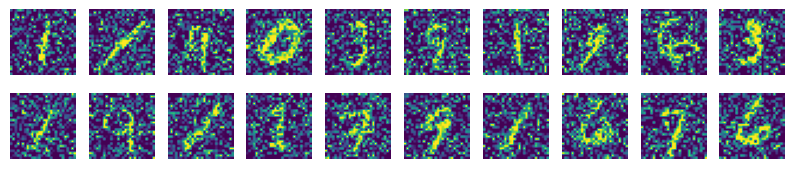

In [102]:
fig,axes = plt.subplots(2,10,figsize=(10,2))
for i in range(2):
    for j in range(10):
        axes[i][j].imshow(test_noisy_images[10*i+j])
        axes[i][j].set_axis_off()

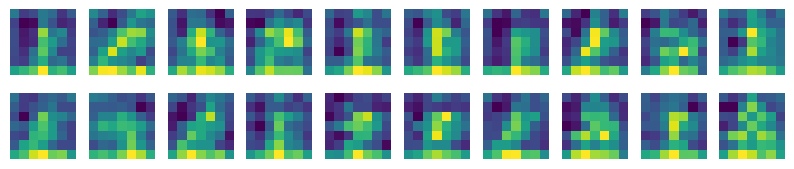

In [103]:
fig,axes = plt.subplots(2,10,figsize=(10,2))
for i in range(2):
    for j in range(10):
        axes[i][j].imshow(noisy_encoder_visualizations[10*i+j])
        axes[i][j].set_axis_off()

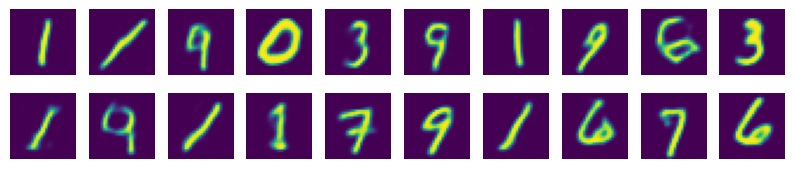

In [104]:
fig,axes = plt.subplots(2,10,figsize=(10,2))
for i in range(2):
    for j in range(10):
        axes[i][j].imshow(noisy_outputs[10*i+j])
        axes[i][j].set_axis_off()

## Variational AutoEncoder

### Encoder

In [11]:
class SamplingLayer(Layer):
    def call(self,inputs):
        mean,log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(mean)) #(BATCH_SIZE,LATENT_DIM)
        z = mean+epsilon*tf.math.exp(0.5*log_var)
        return z

In [12]:
def encoder_model():
    encoder_inputs = Input(shape=(28,28,1))
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Flatten()(x)
    x = Dense(16, activation='relu')(x)
    
    mean = Dense(LATENT_DIM)(x)
    log_var = Dense(LATENT_DIM)(x)
    z = SamplingLayer()([mean,log_var])
    encoder = Model(inputs=encoder_inputs,outputs=[z,mean,log_var])
    return encoder

In [13]:
encoder = encoder_model()
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                              

### Decoder

In [14]:
def decoder_model():
    decoder_inputs = Input(shape=(LATENT_DIM))
    x = Dense(7*7*64,activation='relu')(decoder_inputs)
    x = Reshape((7,7,64))(x)
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    decoder_output = Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    decoder = Model(inputs=decoder_inputs,outputs=decoder_output)
    return decoder

In [15]:
decoder = decoder_model()
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

### Variational Auto Encoder Model

In [16]:
def vae_model():
    vae_inputs = Input(shape=(28,28,1))
    z,mean,log_var = encoder_model()(vae_inputs)
    decoder_outputs = decoder_model()(z)
    vae = Model(inputs=vae_inputs,outputs=decoder_outputs)
    return vae

In [18]:
for i in range(3):
    print(vae.layers[i])

In [17]:
vae = vae_model()
vae.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model_2 (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 model_3 (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134,165
Trainable params: 134,165
Non-trainable params: 0
_________________________________________________________________


### Training

#### Custom Loss

In [20]:
def custom_loss(y_true,y_pred,mean,log_var):
    loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))
    loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
    return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))

#### Custom Training Using Functions

In [21]:
@tf.function
def training_block(x_batch):
    with tf.GradientTape() as tape:
        z,mean,log_var = vae.layers[1](x_batch)
        y_pred = vae.layers[2](z)
        y_true = x_batch 
        loss = custom_loss(y_true,y_pred,mean,log_var)
    partial_grads = tape.gradient(loss,vae.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_grads,vae.trainable_weights))
    return loss

In [119]:
def train(epochs):
    for epoch in range(1,epochs+1):
        total_loss = 0 
        for step, x_batch in enumerate(train_dataset):
            loss = training_block(x_batch)
            total_loss+=loss.numpy()
        print(f'Training starts for epoch number: {epoch}, Loss is: {total_loss/len(train_dataset)}')
    print('Training Complete!!!')

In [120]:
train(EPOCHS)

Training starts for epoch number: 1, Loss is: 151.0045067265875
Training starts for epoch number: 2, Loss is: 150.97019130002428
Training starts for epoch number: 3, Loss is: 150.69092170673488
Training starts for epoch number: 4, Loss is: 150.55612344410562
Training starts for epoch number: 5, Loss is: 150.4782097518335
Training starts for epoch number: 6, Loss is: 150.31905595127364
Training starts for epoch number: 7, Loss is: 150.26749438298032
Training starts for epoch number: 8, Loss is: 150.11063152083096
Training starts for epoch number: 9, Loss is: 149.94517790464857
Training starts for epoch number: 10, Loss is: 149.85619949815043
Training starts for epoch number: 11, Loss is: 149.78453858984017
Training starts for epoch number: 12, Loss is: 149.68825945252692
Training starts for epoch number: 13, Loss is: 149.60389302199675
Training starts for epoch number: 14, Loss is: 149.48184178995695
Training starts for epoch number: 15, Loss is: 149.31866770296253
Training starts for e

In [24]:
scale=1
n=16
grid_x = np.linspace(-scale,scale,16)
grid_y = np.linspace(-scale,scale,16)
print(grid_x,grid_y)

[-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ] [-1.         -0.86666667 -0.73333333 -0.6        -0.46666667 -0.33333333
 -0.2        -0.06666667  0.06666667  0.2         0.33333333  0.46666667
  0.6         0.73333333  0.86666667  1.        ]


1/1 [==============================] - 0s 16ms/step


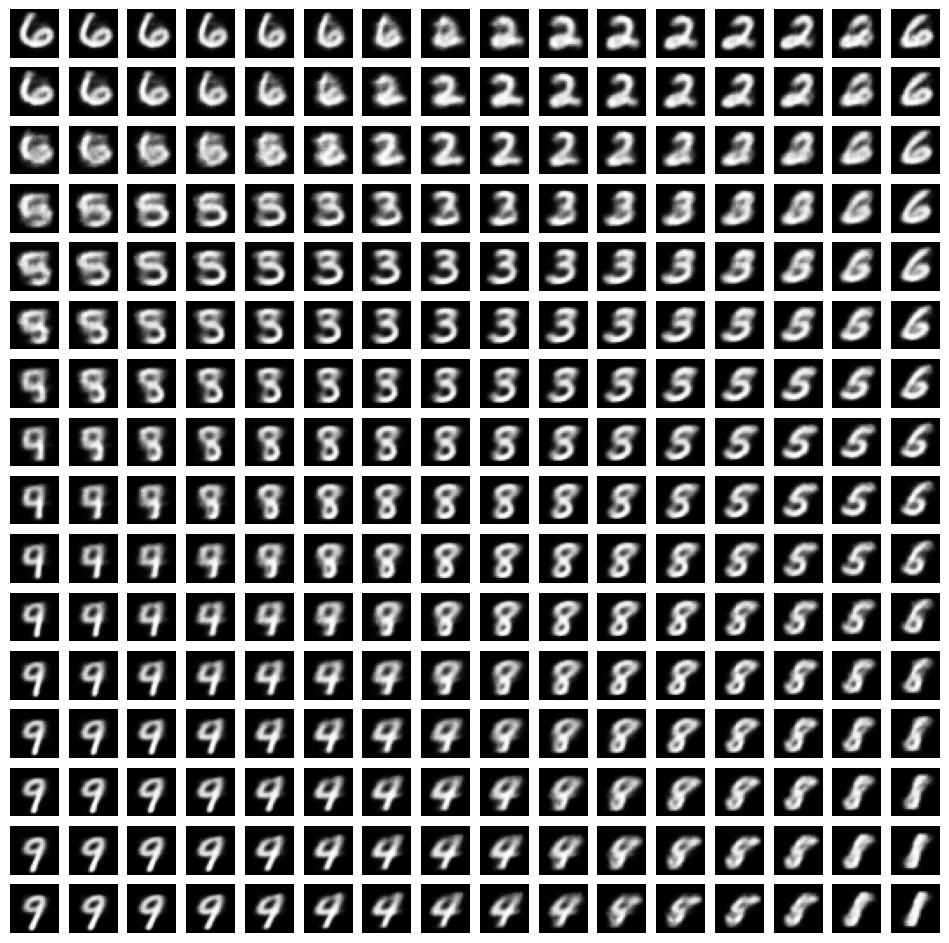

In [121]:
fig, axes = plt.subplots(n,n,figsize=(12,12))
for i,x in enumerate(grid_x):
    for j,y in enumerate(grid_y):
        y_pred = vae.layers[2].predict(np.array([[x,y]]))
        axes[i][j].imshow(y_pred[0],cmap="Greys_r")
        axes[i][j].axis('off')

#### Custom Training By Overriding train_step Function in Tensorflow

In [30]:
class VAE(Model):
    def __init__(self):
        super(VAE,self).__init__()
        self.encoder=encoder_model()
        self.decoder=decoder_model()
        self.loss_tracker=tf.keras.metrics.Mean(name='loss')
        
    @property
    def metrics(self):
        return [self.loss_tracker]
    
    def train_step(self,x_batch):
        with tf.GradientTape() as recorder:
            z,mean,log_var = self.encoder(x_batch)
            y_pred = self.decoder(z)
            y_true = x_batch
            loss = custom_loss(y_true,y_pred, mean, log_var)

        partial_derivatives = recorder.gradient(loss,self.trainable_weights)
        OPTIMIZER.apply_gradients(zip(partial_derivatives, self.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {'loss':self.loss_tracker.result()}

In [31]:
model=VAE()
model.compile(optimizer=OPTIMIZER)
model.fit(train_dataset, epochs=20)

Epoch 1/20
547/547 [==============================] - 5s 5ms/step - loss: 202.6327
Epoch 2/20
547/547 [==============================] - 2s 5ms/step - loss: 188.3391
Epoch 3/20
547/547 [==============================] - 2s 5ms/step - loss: 184.8197
Epoch 4/20
547/547 [==============================] - 2s 5ms/step - loss: 182.5801
Epoch 5/20
547/547 [==============================] - 2s 5ms/step - loss: 181.0087
Epoch 6/20
547/547 [==============================] - 2s 5ms/step - loss: 179.8525
Epoch 7/20
547/547 [==============================] - 2s 5ms/step - loss: 178.9494
Epoch 8/20
547/547 [==============================] - 2s 5ms/step - loss: 178.1152
Epoch 9/20
547/547 [==============================] - 2s 5ms/step - loss: 177.4889
Epoch 10/20
547/547 [==============================] - 2s 5ms/step - loss: 176.7510
Epoch 11/20
547/547 [==============================] - 2s 5ms/step - loss: 176.2458
Epoch 12/20
547/547 [==============================] - 2s 4ms/step - loss: 175.7465
E

In [32]:
model.layers

In [33]:
model.encoder

1/1 [==============================] - 0s 16ms/step


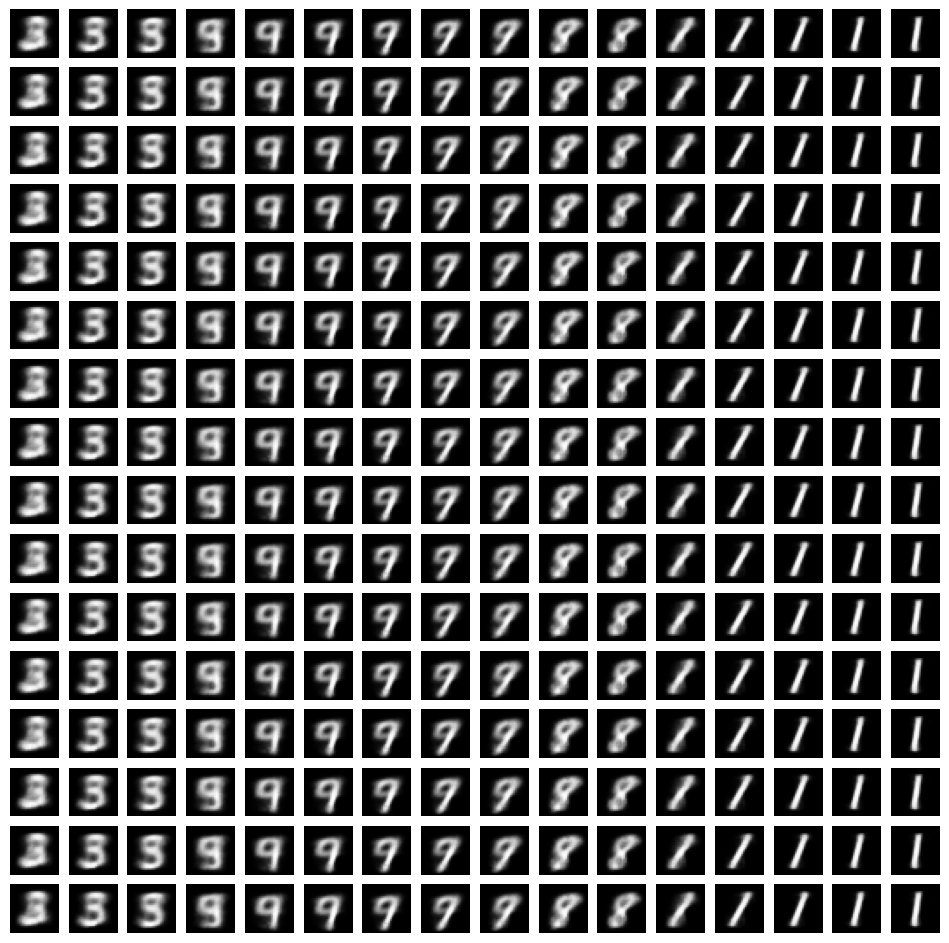

In [35]:
fig, axes = plt.subplots(n,n,figsize=(12,12))
for i,x in enumerate(grid_x):
    for j,y in enumerate(grid_y):
        y_pred = model.decoder.predict(np.array([[x,y]]))
        axes[i][j].imshow(y_pred[0],cmap="Greys_r")
        axes[i][j].axis('off')

#### Lets use a noisy dataset 

In [105]:
def map_noise_to_images_2(image):
    noise_factor = 0.5*tf.random.normal(shape=image.shape)
    image_noisy = noise_factor+image
    image_noisy = tf.clip_by_value(image_noisy,0.0,1.0)
    return image_noisy

In [106]:
train_dataset_with_noise = (
    dataset
    .map(map_noise_to_images_2)
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [107]:
model_2=VAE()
model_2.compile(optimizer=OPTIMIZER)
model_2.fit(train_dataset_with_noise, epochs=20)

Epoch 1/20
547/547 [==============================] - 7s 9ms/step - loss: 443.4387
Epoch 2/20
547/547 [==============================] - 5s 9ms/step - loss: 441.6877
Epoch 3/20
547/547 [==============================] - 5s 8ms/step - loss: 441.7299
Epoch 4/20
547/547 [==============================] - 5s 9ms/step - loss: 441.7113
Epoch 5/20
547/547 [==============================] - 5s 9ms/step - loss: 441.7127
Epoch 6/20
547/547 [==============================] - 5s 9ms/step - loss: 441.6433
Epoch 7/20
547/547 [==============================] - 5s 9ms/step - loss: 441.7423
Epoch 8/20
547/547 [==============================] - 5s 9ms/step - loss: 441.6351
Epoch 9/20
547/547 [==============================] - 5s 9ms/step - loss: 441.6828
Epoch 10/20
547/547 [==============================] - 5s 9ms/step - loss: 441.6957
Epoch 11/20
547/547 [==============================] - 5s 9ms/step - loss: 441.6950
Epoch 12/20
547/547 [==============================] - 5s 9ms/step - loss: 441.7060
E

1/1 [==============================] - 0s 16ms/step


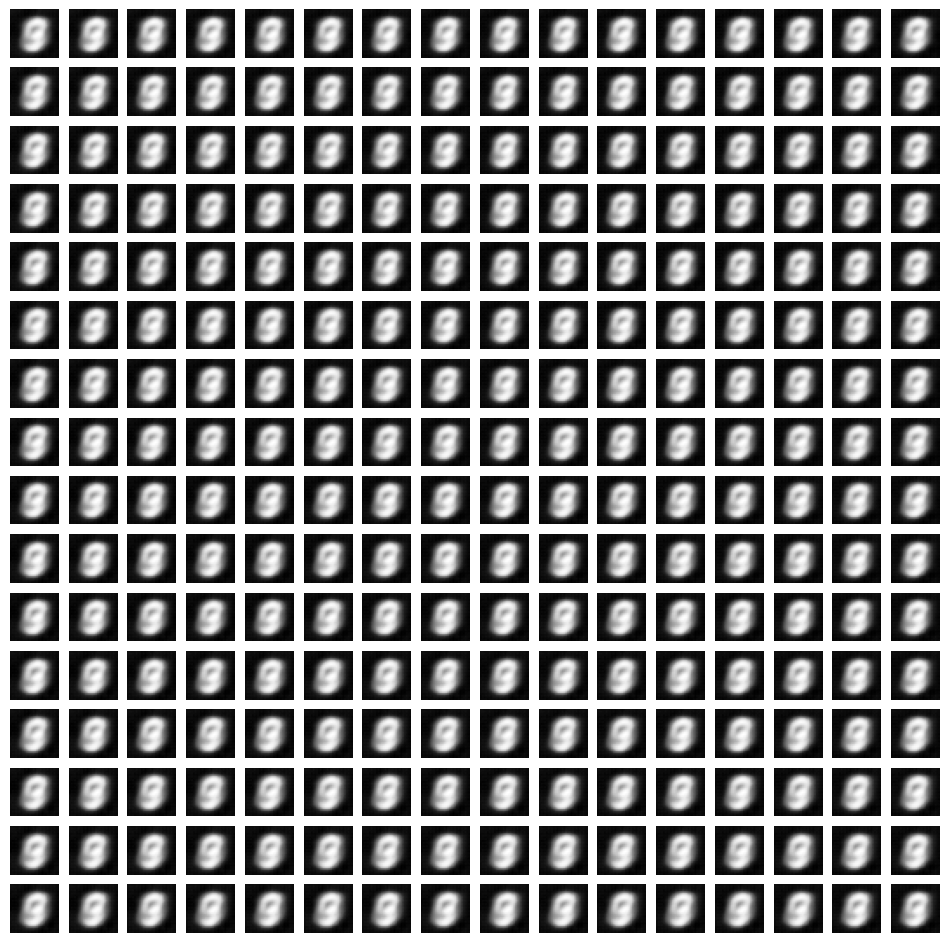

In [108]:
fig, axes = plt.subplots(n,n,figsize=(12,12))
for i,x in enumerate(grid_x):
    for j,y in enumerate(grid_y):
        y_pred = model_2.decoder.predict(np.array([[x,y]]))
        axes[i][j].imshow(y_pred[0],cmap="Greys_r")
        axes[i][j].axis('off')

# Visualize the Latent Space

## Visualize the model called vae

2188/2188 [==============================] - 3s 1ms/step


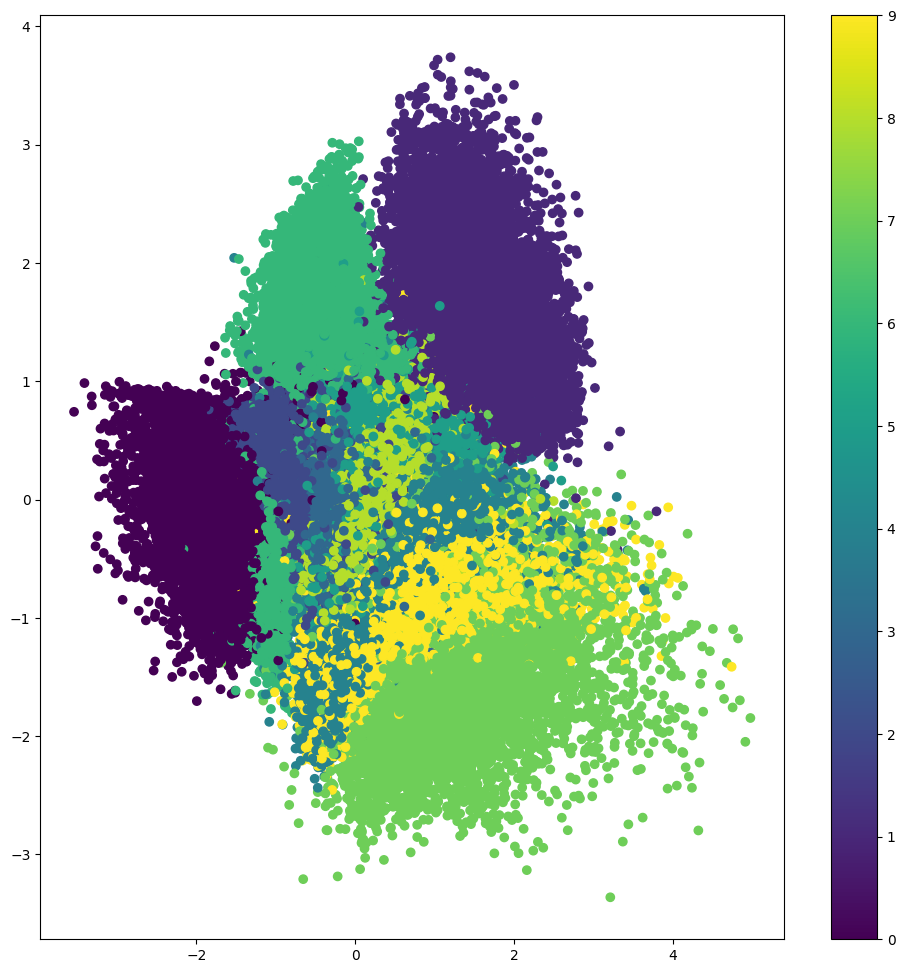

In [122]:
z,_,_=vae.layers[1].predict(mnist_digits)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=mnist_digits_labels)
plt.colorbar()
plt.show()

## Visualize the model called model

2188/2188 [==============================] - 3s 1ms/step


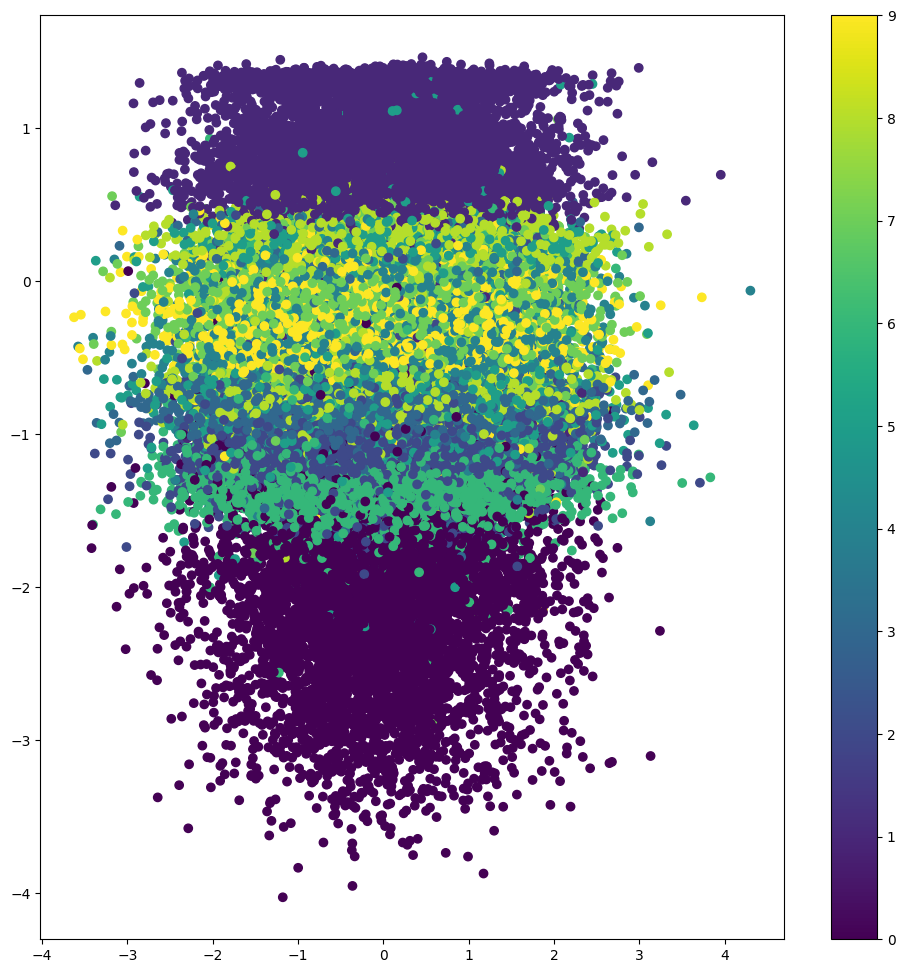

In [34]:
z,_,_=model.encoder.predict(mnist_digits)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=mnist_digits_labels)
plt.colorbar()
plt.show()

## Visualize Model called model_2

In [114]:
noisy_mnist_digits = tf.data.Dataset.from_tensor_slices(mnist_digits).map(map_noise_to_images_2).batch(BATCH_SIZE)

547/547 [==============================] - 5s 9ms/step


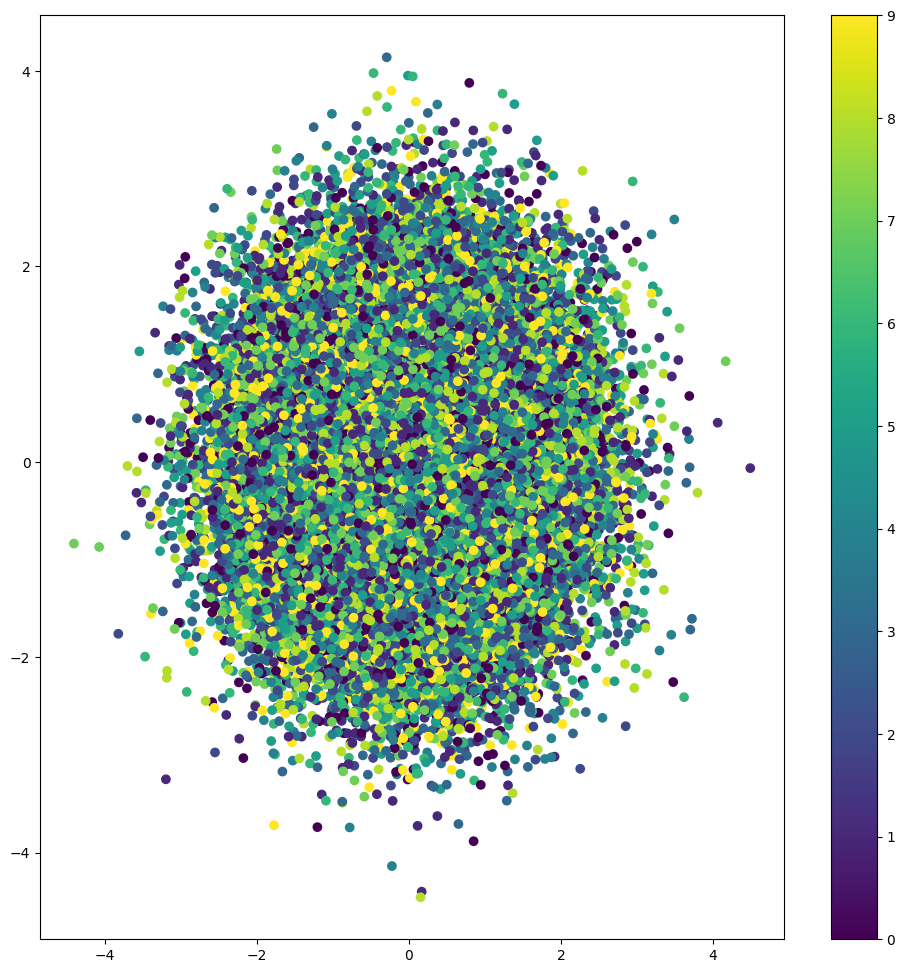

In [115]:
z,_,_=model_2.encoder.predict(noisy_mnist_digits)
plt.figure(figsize=(12,12))
plt.scatter(z[:,0],z[:,1],c=mnist_digits_labels)
plt.colorbar()
plt.show()

Apparantly the VAE did not do very well with noisy data which I believe is due to the fact that the encoder outputs mean and log variance which represent a probability distribution so alot of images are similar to each other after adding noise so the mean and log variance are mixed with another among different digits